In [26]:
using OrdinaryDiffEq, ModelingToolkit, DataDrivenDiffEq, SciMLSensitivity, DataDrivenSparse
using Optimization, OptimizationOptimisers, OptimizationOptimJL, LineSearches, Plots
# Standard Libraries
using LinearAlgebra, Statistics

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs, LuxCUDA, Metal, SimpleDiffEq
gr()
gdev = gpu_device()
rng = StableRNG(1111)

StableRNGs.LehmerRNG(state=0x000000000000000000000000000008af)

In [17]:
function marijuana_data!(du, u, p, t)
    β, s, N = p
    du[1] = - β * (u[1] * u[3])/N
    du[2] =  β * (u[1] * u[3])/N - s * u[2]
    du[3] = s * u[2] 
end

marijuana_data! (generic function with 1 method)

In [19]:
tspan = (0,365)
u0 = [3305059;36686;19186.78]
p_ = [0.05, 0.011, 3360931.78]
prob_data = ODEProblem(marijuana_data!, u0, tspan, p_)
solution_data = solve(prob_data, lsoda(), abstol = 1e-12, reltol = 1e-12, saveat = 0.25)

retcode: Success
Interpolation: 1st order linear
t: 1461-element Vector{Float64}:
   0.0
   0.25
   0.5
   0.75
   1.0
   1.25
   1.5
   1.75
   2.0
   2.25
   2.5
   2.75
   3.0
   ⋮
 362.25
 362.5
 362.75
 363.0
 363.25
 363.5
 363.75
 364.0
 364.25
 364.5
 364.75
 365.0
u: 1461-element Vector{Vector{Float64}}:
 [3.305059e6, 36686.0, 19186.78]
 [3.304822539948473e6, 36821.38758910501, 19287.852462421866]
 [3.304584852297026e6, 36957.62928830922, 19389.29841466428]
 [3.3043459327084664e6, 37094.72708327505, 19491.12020825805]
 [3.3041057768194377e6, 37232.682980345635, 19593.320200216313]
 [3.303864380240294e6, 37371.49900659883, 19695.900753106864]
 [3.3036217385550803e6, 37511.177209815054, 19798.864235104505]
 [3.3033778473215187e6, 37651.71965847201, 19902.213020009367]
 [3.3031327020709263e6, 37793.12844171544, 20005.94948735851]
 [3.3028862983081713e6, 37935.405669341635, 20110.076022486774]
 [3.3026386315116514e6, 38078.55347179209, 20214.595016556395]
 [3.302389697133264e6, 38

In [20]:
X_data = Array(solution_data)
t_data = solution_data.t
susceptible_data = X_data[1, :]
endemic_data = X_data[2, :]
users_data = X_data[3, :]
x̄ = mean(X_data, dims = 2)
noise_magnitude = 5e-3
Xₙ = X_data .+ (noise_magnitude * x̄) .* randn(rng, eltype(X_data), size(X_data))

3×1461 Matrix{Float64}:
     3.31729e6      3.31125e6      3.2969e6  …  40031.9        48457.3
 34318.4        34919.5        39282.8              7.51738e5      7.38359e5
 19274.6        21384.0        24870.6              2.58406e6      2.58375e6

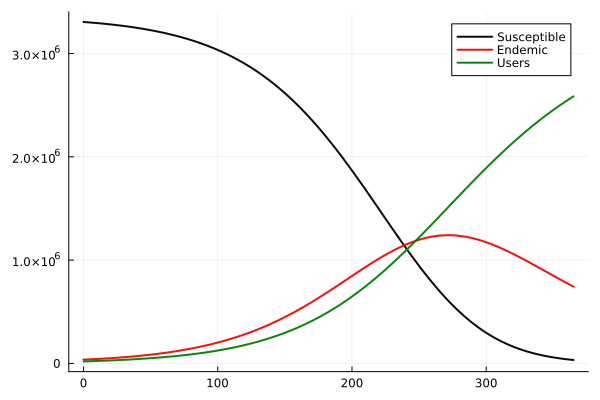

In [21]:
plot(t_data,susceptible_data, alpha = 0.95, color = :black, label = ["Susceptible" nothing], linewidth=2)
plot!(t_data,endemic_data, alpha = 0.95, color = :red, label = ["Endemic" nothing], linewidth=2)
plot!(t_data,users_data, alpha = 0.95, color = :green, label = ["Users" nothing], linewidth=2)

In [22]:
function marijuana!(du, u, p, t)
    β, γ, s, N = p
    du[1] = - β * (u[1] * u[3])/N
    du[2] =  (β * (u[1] * u[3])/N) - (s * u[2])
    du[3] = s * u[2] - γ * u[3]
    du[4] = γ * u[3]
end

marijuana! (generic function with 1 method)

In [31]:
tspan = (0.0f0,365.0f0)
println(tspan)
u0 = Float32.([3305059;36686;19186.78;0])
p_ = Float32.([0.05, 0.105625, 0.011, 3360931.78])
prob = ODEProblem(marijuana!, u0, tspan, p_)
solution = solve(prob, Vern7(), abstol = 1e-12, reltol = 1e-12, saveat = 0.25)

(0.0f0, 365.0f0)


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/j3YjA/src/integrator_interface.jl:589


retcode: MaxIters
Interpolation: 1st order linear
t: 95-element Vector{Float32}:
  0.0
  0.25
  0.5
  0.75
  1.0
  1.25
  1.5
  1.75
  2.0
  2.25
  2.5
  2.75
  3.0
  ⋮
 20.75
 21.0
 21.25
 21.5
 21.75
 22.0
 22.25
 22.5
 22.75
 23.0
 23.25
 23.5
u: 95-element Vector{Vector{Float32}}:
 [3.305059f6, 36686.0, 19186.78, 0.0]
 [3.305059f6, 36716.223, 18891.854, 503.7375]
 [3.305059f6, 36852.22, 18498.646, 997.39]
 [3.305059f6, 36974.758, 18116.156, 1480.7823]
 [3.305059f6, 37097.023, 17744.451, 1954.2279]
 [3.305059f6, 37210.633, 17382.688, 2417.9954]
 [3.305059f6, 37315.902, 17030.877, 2872.3472]
 [3.305059f6, 37415.047, 16688.656, 3317.5378]
 [3.305059f6, 37510.223, 16355.399, 3753.8022]
 [3.305059f6, 37606.184, 16031.118, 4181.391]
 [3.305059f6, 37697.69, 15715.547, 4600.518]
 [3.305059f6, 37784.703, 15408.446, 5011.459]
 [3.305059f6, 37867.785, 15109.601, 5414.3735]
 ⋮
 [3.305059f6, 38195.72, 5725.135, 22349.879]
 [3.305059f6, 38161.305, 5679.5596, 22500.504]
 [3.305059f6, 38126.203, 5

In [ ]:
X = Array(solution)
t = gdev(Array(solution.t))
Xdev= gdev(Array(solution))
susceptible = Xdev[1, :] 
endemic = Xdev[2, :] 
users = Xdev[3, :] 
treatment = Xdev[4, :]
x̄ = mean(X, dims = 2)
noise_magnitude = 5e-3
noise_vec = X .+ (noise_magnitude * x̄) .* randn(rng, eltype(X), size(X))
Xₙ = map(Float32, noise_vec)

In [ ]:
plot(t,susceptible, alpha = 0.75, color = :black, label = ["Susceptible" nothing], linewidth=2)
plot!(t,endemic, alpha = 0.75, color = :red, label = ["Endemic" nothing], linewidth=2)
plot!(t,users, alpha = 0.75, color = :green, label = ["Users" nothing], linewidth=2)
plot!(t,treatment, alpha = 0.75, color = :blue, label = ["Treatment" nothing], linewidth=2)

In [ ]:
println(t)
s = scatter!(t, transpose(Xₙ), color = :red, label = ["Noisy Data" nothing])

In [ ]:
# Define the ReLU activation function
# function myrelu(x)
#     return max(0, x)
# end
rbf(x) = exp.(-(x .^ 2))
# rbf(x) = myrelu(x)
const U = Lux.Chain(Lux.Dense(4, 16, rbf),Lux.Dense(16, 1))

# Get the initial parameters and state variables of the model
p, st = Lux.setup(rng, U)
const _st = st


In [ ]:
# Define the hybrid model (Neural Network)
function ude_dynamics!(du, u, p, t, p_true)
    û = U(u, p, _st)[1] # Network prediction
    du[1] = -p_true[1] * (u[1] * u[3])/p_true[4]
    du[2] =  (p_true[1] * (u[1] * u[3])/p_true[4]) - (p_true[3] * û[1])
    du[3] = p_true[3] * u[2] - p_true[2] * u[3]
    du[4] = u[3] * û[1]
end

In [ ]:
# Closure with the known parameter
nn_dynamics!(du, u, p, t) = ude_dynamics!(du, u, p, t, p_)
# Define the problem
prob_nn = ODEProblem(nn_dynamics!, Xₙ[:, 1], tspan, p)

function predict(θ, X = Xₙ[:, 1], T = t)
    _prob = remake(prob_nn, u0 = X, tspan = (T[1], T[end]), p = θ)
    Array(solve(_prob, Vern7(), saveat = T,
                abstol = 1e-6, reltol = 1e-6,
                sensealg=QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end

In [ ]:
function loss(θ)
    X̂ = predict(θ)
    mean(abs2, Xₙ .- X̂)
end

losses = Float32[]

callback = function (p, l)
    push!(losses, l)
    if length(losses) % 50 == 0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    return false
end

In [ ]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentVector{Float32}(p))

res1 = Optimization.solve(optprob, OptimizationOptimisers.Adam(), callback = callback, maxiters = 5000)
println("Training loss after $(length(losses)) iterations: $(losses[end])")

optprob2 = Optimization.OptimizationProblem(optf, res1.u)
res2 = Optimization.solve(optprob2,  LBFGS(linesearch = HagerZhang()), callback = callback, maxiters = 1000)
println("Final training loss after $(length(losses)) iterations: $(losses[end])")

In [ ]:
# Rename the best candidate
p_trained = res2.u

# Plot the losses
pl_losses = plot(1:5000, losses[1:5000], yaxis = :log10, xaxis = :log10,
                 xlabel = "Iterations", ylabel = "Loss", label = "ADAM", color = :blue)
plot!(5001:length(losses), losses[5001:end], yaxis = :log10, xaxis = :log10,
      xlabel = "Iterations", ylabel = "Loss", label = "LBFGS", color = :red)

In [ ]:
## Analysis of the trained network
# Plot the data and the approximation
ts = first(solution.t):(mean(diff(solution.t)) / 2):last(solution.t)
X̂ = predict(p_trained, Xₙ[4, :], ts)
# Trained on noisy data vs real solution
pl_trajectory = plot(ts, transpose(X̂), xlabel = "t", ylabel = "T(t)", color = :red,
                     label = ["UDE Approximation" nothing])
plot!(solution.t, transpose(Xₙ), color = :black, label = ["Measurements" nothing])
# scatter!(solution.t, transpose(Xₙ), color = :white, label = ["Measurements" nothing])

In [ ]:
# Ideal unknown interactions of the predictor
Ȳ = [p_[2] * (X̂[1, :] .* X̂[2, :])'; p_[3] * (X̂[1, :] .* X̂[2, :])']
# Neural network guess
Ŷ = U(X̂, p_trained, st)[1]

pl_reconstruction = plot(ts, transpose(Ŷ), xlabel = "t", ylabel = "U(x,y)", color = :red,
                         label = ["UDE Approximation" nothing])
plot!(ts, transpose(Ȳ), color = :black, label = ["True Interaction" nothing])

In [ ]:
# Plot the error
pl_reconstruction_error = plot(ts, norm.(eachcol(Ȳ - Ŷ)), yaxis = :log, xlabel = "t",
                               ylabel = "L2-Error", label = nothing, color = :red)
pl_missing = plot(pl_reconstruction, pl_reconstruction_error, layout = (2, 1))
pl_overall = plot(pl_trajectory, pl_missing)